In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import warnings
import os
import sys
warnings.filterwarnings("ignore")


In [3]:
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/Users/daniel/iSpec/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

In [4]:

import logging
LOG_LEVEL = "error"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

In [5]:
# plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [6]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def smooth(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten(x, y, return_trend=False):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], 3)
    if return_trend:
        return y / np.polyval(p, x), np.polyval(p, x)
    return y / np.polyval(p, x)

def interpolate_spectrum(x, y, template_wav):
    f1  = interpolate.interp1d(x, y, kind = 'linear')
    return f1(template_wav)
    
def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu

In [7]:
def get_spectrum(spec, orders):
    spec_data = pf.getdata(spec)
    wav = spec_data[3,:,:]
    flux = spec_data[0,:,:]# / spec_data[2,:,:]
    
    all_wav, all_flux = [], []
    for w, f in zip(wav[orders], flux[orders]):
        ivars = np.ones_like(w)
        mu = fit_continuum(w, f, ivars)
        f /= mu
        all_wav.extend(w)
        all_flux.extend(f)

    all_wav, all_flux = np.array(all_wav), np.array(all_flux)
    all_flux /= np.median(all_flux)
    all_flux = smooth(all_wav, all_flux, factor=0.08)
    return all_wav, all_flux

In [8]:
def rv_ccf_mask(spectrum, diagnose=False, ax=None):
#     mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.F0.360_698nm/mask.lst"
    mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst"
    ccf_mask = ispec.read_cross_correlation_mask(mask_file)

    models, ccf = ispec.cross_correlate_with_mask(spectrum, ccf_mask, \
                            lower_velocity_limit=-200, upper_velocity_limit=200, \
                            velocity_step=1.0, mask_depth=0.1, mask_size=2.0, 
                            fourier=False, only_one_peak=True)
    
    if diagnose:
        if ax is None:
            fig, ax = plt.subplots()
        plt.plot(ccf['x'], ccf['y'], lw=1, color='b', linestyle='-', marker='', markersize=1, markeredgewidth=0, markerfacecolor='b', zorder=1)
        plt.fill_between(ccf['x'], ccf['y']+ccf['err'], ccf['y']-ccf['err'], color='#CCCCCC')
        for model in models:
            plt.plot(ccf['x'], model(ccf['x']), lw=1, color='r', linestyle='-', marker='', markersize=1, markeredgewidth=0, markerfacecolor='r', zorder=2)
        plt.show()
#     if len(models) > 1:
#         return models[0].mu(), models[1].mu()#, models[1].mu(), models[1].emu()
    return models[0].mu(), models[0].emu()

## Get primary RVs

In [18]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))
epochs = np.arange(len(all_spectra_files))
m = ~((epochs == 60) | (epochs == 15))
all_spectra_files = all_spectra_files[m]

orders = [18,19,20,21,22,23,24,25,26]
#18,19,20,21,22,23,24,25,

all_rv, all_rv_err = [], []
times = []
all_spectra = []

for spec in tqdm.tqdm(all_spectra_files[:]):

    wav, flux = get_spectrum(spec, orders)
    meta = pf.getheader( spec )
    times.append(meta['BJD-MID'])
    
    m = wav < 5500
    wav, flux = wav[m], flux[m]
    flux /= np.median(flux)
    np.savetxt(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt", list(zip(wav / 10, flux, np.ones_like(flux) * 0.01)))
    star_spectrum = ispec.read_spectrum(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt")
    
    all_spectra.append(star_spectrum)
    
    rv, rv_err = rv_ccf_mask(star_spectrum, diagnose=False)
    all_rv.append(rv)
    all_rv_err.append(rv_err)

100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


Text(0, 0.5, 'RV [km/s]')

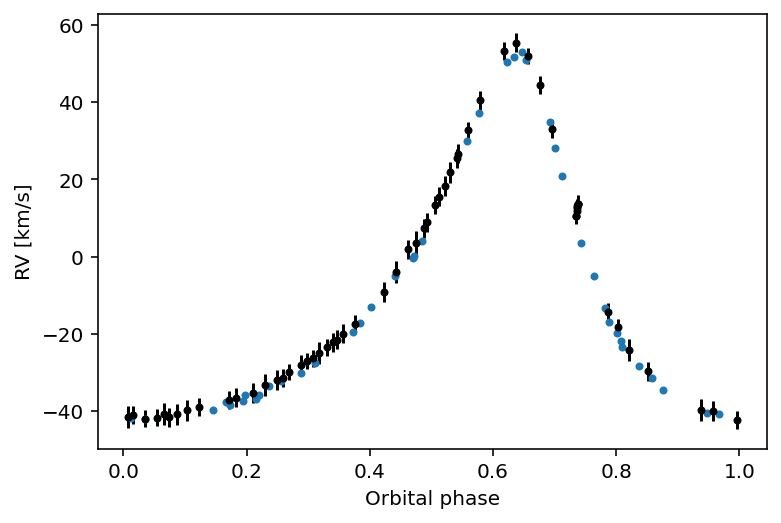

In [19]:
RV = np.array(all_rv)
import astropy.units as u
bvcs = []
for spec in all_spectra_files:
    meta = pf.getheader( spec )
    bvcs.append(meta['BVC'])
    
RV = (RV * u.km / u.s) + (bvcs * u.km / u.s) + (RV * u.km / u.s) * (bvcs * u.km / u.s) / (299792.458 * u.km / u.s)

bischoff_x, bischoff_y = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1)).T

porb = 51.4213
plt.errorbar((np.array(times) + 2400000) % porb / porb, RV.value, yerr=all_rv_err, fmt='.k')

plt.plot((bischoff_x + 2457000) % porb / porb, bischoff_y, '.')

plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]')

In [28]:
np.savetxt('data/RV/SONG.txt', list(zip(np.array(times), RV.value, all_rv_err)))

## Create primary template by shifting and stacking

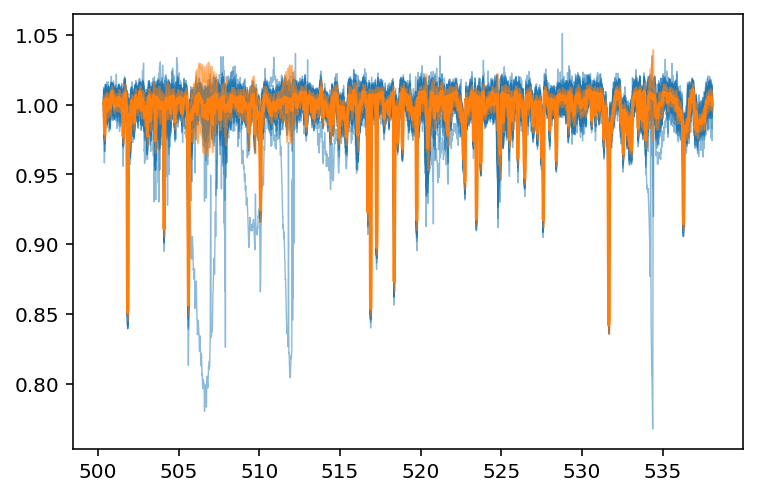

In [20]:
corr_spectra = []
wavelengths = np.linspace(star_spectrum['waveobs'].min()+1, star_spectrum['waveobs'].max()-1, 6142)
coadded_spectrum = ispec.create_spectrum_structure(wavelengths)

for spectra, rv in zip(all_spectra, all_rv):
    corr = np.copy(spectra)
    corr = ispec.correct_velocity(corr, rv)
    
    corr = ispec.resample_spectrum(corr, wavelengths, zero_edges=True)
    corr_spectra.append(corr)
    plt.plot(corr['waveobs'], corr['flux'], alpha=0.5, c='C0', lw=0.7)

corr_spectra = np.array(corr_spectra)
coadded_spectrum['flux'] = np.median(corr_spectra['flux'], axis=0)
coadded_spectrum['err'] = np.std(corr_spectra['flux'], axis=0)

plt.plot(coadded_spectrum['waveobs'], coadded_spectrum['flux'], c='C1')
plt.fill_between(coadded_spectrum['waveobs'], coadded_spectrum['flux'] - coadded_spectrum['err'], coadded_spectrum['flux'] + coadded_spectrum['err'], color='C1', alpha=0.5, zorder=50)

In [21]:
all_rv_secondary = []
corr_subtracted_spectra = []
for corr in corr_spectra:
    corr_subtracted = ispec.create_spectrum_structure(corr['waveobs'])
    corr_subtracted['flux'] = corr['flux'] - coadded_spectrum['flux']# + 1
    corr_subtracted['err'] = coadded_spectrum['err']
    
    corr_subtracted_spectra.append(corr_subtracted)
#     plt.plot(corr_subtracted['waveobs'], corr_subtracted['flux'], lw=0.7)
    
# plt.ylim(0.9, 1.05)
    rv, rv_err = rv_ccf_mask(corr_subtracted, diagnose=False)
    all_rv_secondary.append(rv)

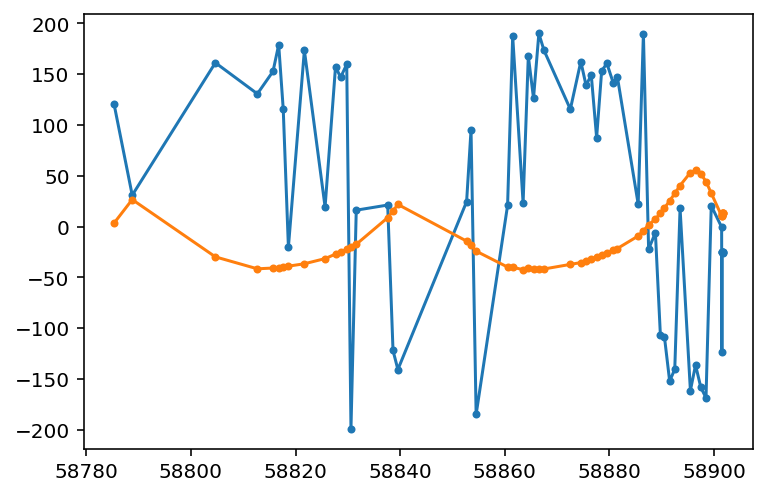

In [22]:
plt.plot(times, all_rv_secondary, '.-')
plt.plot(times, RV, '.-')

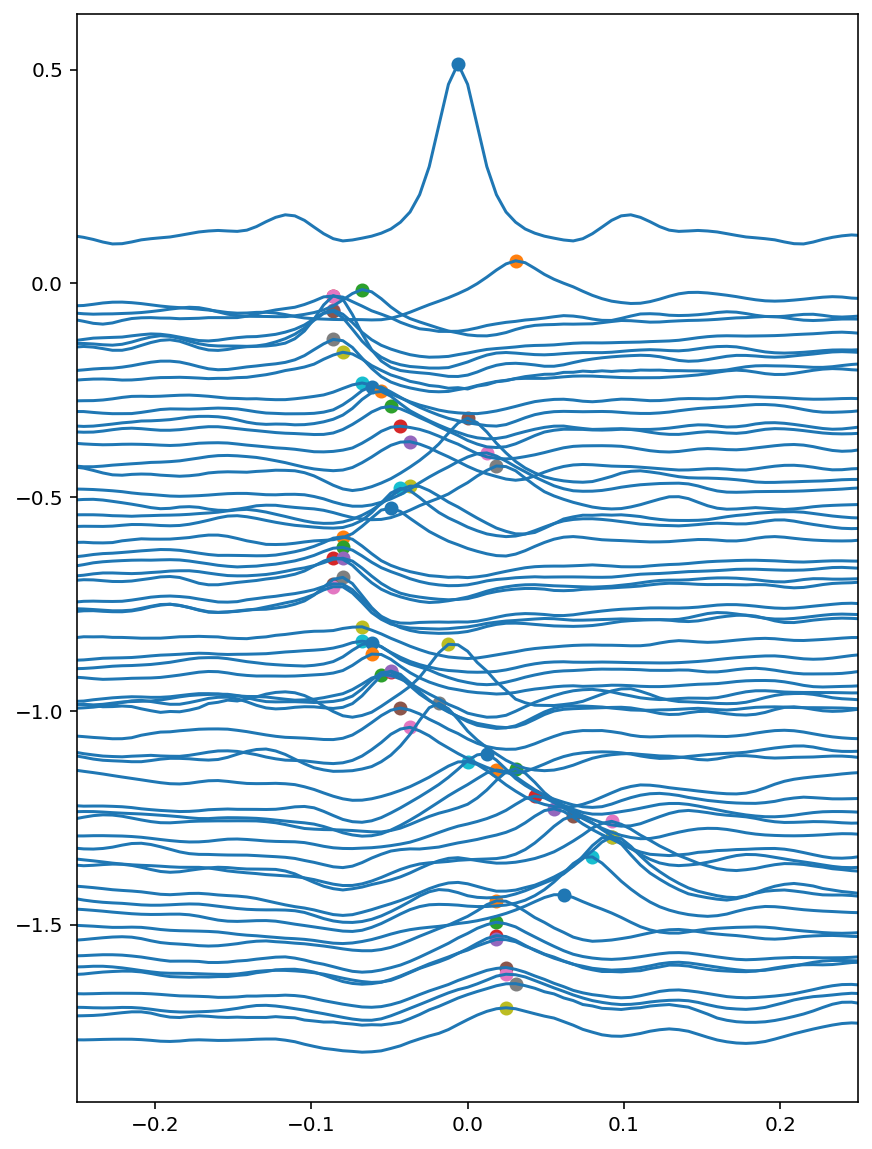

In [23]:
import tqdm

plt.figure(figsize=[7,10])

wav_shift_secondary = []

for i, corr in enumerate(corr_subtracted_spectra):
    acor = np.correlate(corr_subtracted_spectra[0]['flux'], corr['flux'], mode='full')
    df = wavelengths[1] - wavelengths[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    
    plt.plot(lags, acor - i*0.03, c='C0')
    
    m = (lags < 0.25) & (lags > -0.25)
    idx = np.argmax(acor[m])
    plt.scatter(lags[m][idx], acor[m][idx]-i*0.03)
    
    wav_shift_secondary.append(lags[m][idx])
    plt.xlim(-0.25, 0.25)

# WHY IS THERE A SIGNAL HERE??? WHY ????????? 

In [24]:
RV_secondary = (299792.458 * u.km / u.s) * ((-1*np.array(wav_shift_secondary)) / np.mean(wavelengths))

In [25]:
(0.5 * np.max(RV)), (0.5*np.max(RV_secondary))

(<Quantity 27.73592344 km / s>, <Quantity 24.83050316 km / s>)

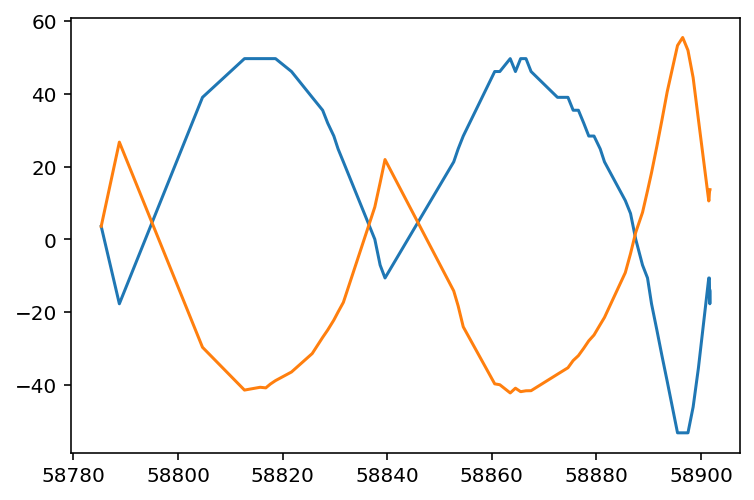

In [26]:
plt.plot(times, RV_secondary)
plt.plot(times, RV)